In [55]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import math
import numpy as np
pd.options.mode.chained_assignment = None
import geopy.distance

In [ ]:
"""
file = open('didi.txt','r') 
urls=file.read().split()
for i in range(len(urls)):
    print ('Now processing day '+str(i),end='\r')
    urllib.request.urlretrieve(urls[i],'day_'+str(i)+'.gz')
"""

In [11]:
column_names = ['Driver_ID','Order_ID','Time_Stamp','Longitude','Latitude']
column_dtypes = {'Driver_ID':object,'Order_ID':object,'Time_Stamp':np.int64,'Longitude':np.float64,'Latitude':np.float64}
df_raw=pd.read_csv('./gps_20161201/gps_20161201', skiprows=1,names=column_names,dtype=column_dtypes)
df_raw=df_raw.sort_values(by=['Driver_ID','Order_ID','Time_Stamp']).reset_index(drop=True)

In [14]:
df_raw.shape

(23654135, 5)

In [12]:
Lat_max,Long_max,Lat_min,Long_min=34.241, 108.943,34.234, 108.9415
x_pi = 3.14159265358979324 * 3000.0 / 180.0
pi = 3.1415926535897932384626  
a = 6378245.0  
ee = 0.00669342162296594323  

In [13]:
def _transformlat(lng, lat):
    ret = -100.0 + 2.0 * lng + 3.0 * lat + 0.2 * lat * lat + \
          0.1 * lng * lat + 0.2 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lat * pi) + 40.0 *
            math.sin(lat / 3.0 * pi)) * 2.0 / 3.0
    ret += (160.0 * math.sin(lat / 12.0 * pi) + 320 *
            math.sin(lat * pi / 30.0)) * 2.0 / 3.0
    return ret
def _transformlng(lng, lat):
    ret = 300.0 + lng + 2.0 * lat + 0.1 * lng * lng + \
          0.1 * lng * lat + 0.1 * math.sqrt(math.fabs(lng))
    ret += (20.0 * math.sin(6.0 * lng * pi) + 20.0 *
            math.sin(2.0 * lng * pi)) * 2.0 / 3.0
    ret += (20.0 * math.sin(lng * pi) + 40.0 *
            math.sin(lng / 3.0 * pi)) * 2.0 / 3.0
    ret += (150.0 * math.sin(lng / 12.0 * pi) + 300.0 *
            math.sin(lng / 30.0 * pi)) * 2.0 / 3.0
    return ret
def gcj02_to_wgs84(lng, lat):
    dlat = _transformlat(lng - 105.0, lat - 35.0)
    dlng = _transformlng(lng - 105.0, lat - 35.0)
    radlat = lat / 180.0 * pi
    magic = math.sin(radlat)
    magic = 1 - ee * magic * magic
    sqrtmagic = math.sqrt(magic)
    dlat = (dlat * 180.0) / ((a * (1 - ee)) / (magic * sqrtmagic) * pi)
    dlng = (dlng * 180.0) / (a / sqrtmagic * math.cos(radlat) * pi)
    mglat = lat + dlat
    mglng = lng + dlng
    return [lng * 2 - mglng, lat * 2 - mglat]

In [15]:
df_WGS84=pd.DataFrame(df_raw.apply(lambda x: gcj02_to_wgs84(x.Longitude, x.Latitude), axis=1),columns=['WGS84'])
df_projected=pd.concat([df_raw.loc[:,['Driver_ID','Order_ID','Time_Stamp']],
                        pd.DataFrame(df_WGS84.WGS84.str[0]).rename(columns={'WGS84':'Longitude'}),
                        pd.DataFrame(df_WGS84.WGS84.str[1]).rename(columns={'WGS84':'Latitude'})],axis=1)
df_projected.to_pickle('gps_20161201_processed')

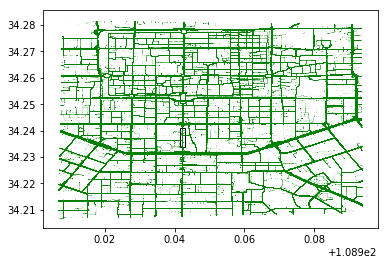

In [16]:
x=df_projected.Longitude.tolist()
y=df_projected.Latitude.tolist()
fig, ax = plt.subplots()
plt.plot(x,y,'g*',markersize=0.01)
currentAxis = plt.gca()
Lat_max,Long_max,Lat_min,Long_min
currentAxis.add_patch(Rectangle((Long_min, Lat_min), Long_max-Long_min, Lat_max-Lat_min,
                      fill=None))
plt.show()

In [104]:
df_section=df_projected[(Long_min<=df_projected.Longitude)&
                        (df_projected.Longitude<=Long_max)&
                        (Lat_min<=df_projected.Latitude)&
                        (df_projected.Latitude<=Lat_max)]

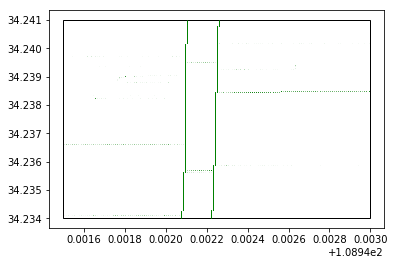

In [102]:
x=df_section.Longitude.tolist()
y=df_section.Latitude.tolist()
fig, ax = plt.subplots()
plt.plot(x,y,'g*',markersize=0.01)
currentAxis = plt.gca()
Lat_max,Long_max,Lat_min,Long_min
currentAxis.add_patch(Rectangle((Long_min, Lat_min), Long_max-Long_min, Lat_max-Lat_min,
                      fill=None))
plt.show()

In [105]:
df_section['TimeDiff']=df_section.groupby(['Driver_ID','Order_ID']).Time_Stamp.diff()
df_section['time']=pd.to_datetime(df_section.Time_Stamp, unit='s').dt.strftime('%r')
df_section['Last_Lon']=df_section.groupby(['Driver_ID','Order_ID']).Longitude.shift(1)
df_section['Last_Lat']=df_section.groupby(['Driver_ID','Order_ID']).Latitude.shift(1)
df_section=df_section.dropna()
df_section['Dist']=df_section.apply(lambda x: geopy.distance.vincenty((x.Last_Lat,x.Last_Lon),(x.Latitude,x.Longitude)).miles,axis=1)
df_section['Speed']=df_section['Dist']/df_section['TimeDiff']*3600
columns_sel=['Time_Stamp','time','Speed']
df_section=df_section.loc[:,columns_sel]

In [ ]:
Prediction_N=pd.read_csv('./Predictions/Predictions_north.csv')
Prediction_S=pd.read_csv('./Predictions/Predictions_south.csv')